# S2 Geomedian plus TMAD

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pyproj import Transformer

import datacube

import sys
sys.path.append('../Scripts')
from deafrica_dask import create_local_dask_cluster
from s2_geomedian import run_tile


In [2]:
create_local_dask_cluster(n_workers=14,threads_per_worker=1)

Client Scheduler: tcp://127.0.0.1:45629 Dashboard: /user/fangfy/proxy/8787/status,Cluster Workers: 14 Cores: 14 Memory: 104.37 GB


## Generate seasonal geomedian for 2017 and 2019

In [3]:

def run_gm_tmad(lat, lon, tilesize, cloud_buffer, maxcloud, annual_only=False, fourmonthly=False, outpath='s2_geomedian_tmad', 
                bands=['blue','green','red','nir_2','swir_1']):
    
    # convert to projected centre coordinates
    transformer = Transformer.from_crs("epsg:4326", "epsg:6933", always_xy=True)
    x0, y0 = transformer.transform(lon, lat)

    x = (x0-tilesize/2, x0+tilesize/2)
    y = (y0-tilesize/2, y0+tilesize/2)

    if annual_only:
        times = [("2019-01-01", "2019-12-31")]
    elif fourmonthly:
        times = [
            ("2019-01-01", "2019-04-30"),
            ("2019-05-01", "2019-08-31"),
            ("2019-09-01", "2019-12-31"),]
    else:
        times = [
        # quarter
        ("2019-01-01", "2019-03-31"),
        ("2019-04-01", "2019-06-30"),
        ("2019-07-01", "2019-09-30"),
        ("2019-10-01", "2019-12-31"),
        # 6 month
        #("2019-01-01", "2019-06-30"),
        #("2019-07-01", "2019-12-31"),
        # 12 month
        ("2019-01-01", "2019-12-31"),
        ]

    dask_chunks = {'time': -1, 'x':200, 'y': 200}

    filenames = []
    for time in times:
        if cloud_buffer>0:
            filename = "%s/cloud_cover_0_%d/s2_%s_%s_%d_%d_buffer%d.nc"%(outpath, maxcloud, time[0], time[1], x0, y0, cloud_buffer)
        else:
            filename = "%s/cloud_cover_0_%d/s2_%s_%s_%d_%d.nc"%(outpath, maxcloud, time[0], time[1], x0, y0)
        print(filename)
        filenames.append(filename)
    
        gm = run_tile(x, y, time, filename,
                  cloud_labels=[8,9,10], cloud_buffer=cloud_buffer, bad_labels=[0,1,3], 
                  bands=bands, # only testing a few bands for speed
                  redo=False, tmad=True,
                  dask_chunks = dask_chunks, cloud_cover=[0, maxcloud],
                 )


In [4]:
maxcloud = 100
tilesize = 20000
cloud_buffer=0

latlons = [(-33.7, 19.515),
           ]

bands=['blue','green','red','nir','swir_1','swir_2']

for lat, lon in latlons:
    run_gm_tmad(lat, lon, tilesize, cloud_buffer, maxcloud, annual_only=True, bands=bands)


s2_geomedian_tmad/cloud_cover_0_100/s2_2019-01-01_2019-12-31_1882929_-4061168.nc


## Eastern Africa locations

In [5]:
maxcloud = 100
tilesize = 50000 # 50 km
cloud_buffer=0

latlons = [(-0.629425, 34.135745),
            (11.521710, 37.489409),
            #(-0.295307, 38.442294),
           (12.263660, 37.024471),
           ]

bands=['blue','green','red','red_edge_1','red_edge_2','red_edge_3','nir_1', 'nir_2','swir_1','swir_2']

for lat, lon in latlons:
    run_gm_tmad(lat, lon, tilesize, cloud_buffer, maxcloud, annual_only=True, bands=bands)


s2_geomedian_tmad/cloud_cover_0_100/s2_2019-01-01_2019-12-31_3293631_-80296.nc
s2_geomedian_tmad/cloud_cover_0_100/s2_2019-01-01_2019-12-31_3617213_1460236.nc
s2_geomedian_tmad/cloud_cover_0_100/s2_2019-01-01_2019-12-31_3572353_1552909.nc


2.4067945 4.1993585 2.5801868


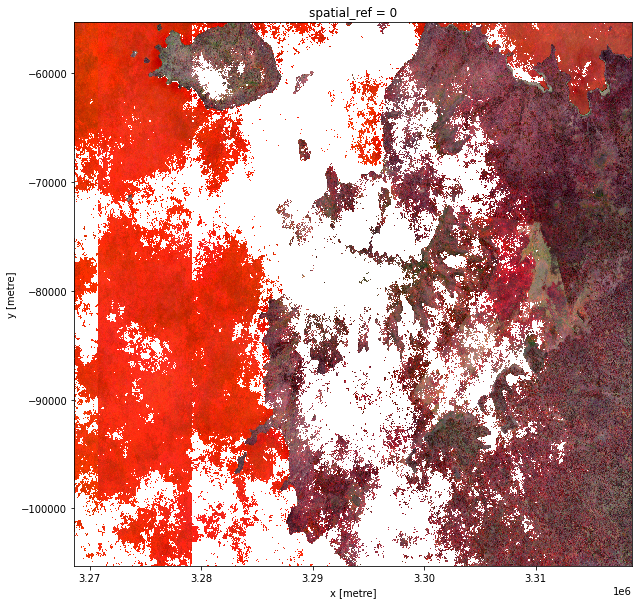

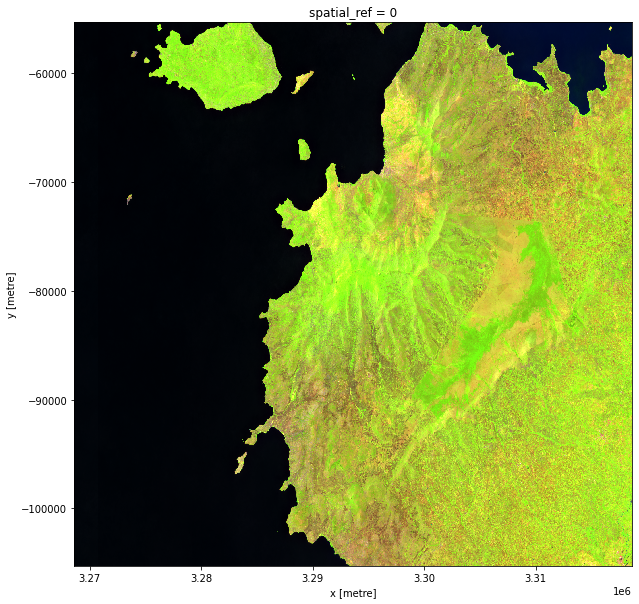

In [18]:
import xarray as xr
import numpy as np

fname = "s2_2019-01-01_2019-12-31_1882929_-4061168.nc"
fname = "s2_2019-01-01_2019-12-31_3293631_-80296.nc"
#fname= "s2_2019-01-01_2019-12-31_3617213_1460236.nc"
#fname = "s2_2019-01-01_2019-12-31_3572353_1552909.nc"
data = xr.open_dataset(f"s2_geomedian_tmad/cloud_cover_0_100/{fname}")
data['bcmad'] = -np.log(data.bcmad.where(data.bcmad>0))
data['emad'] = -np.log(data.emad.where(data.emad>0))
data['smad'] = -np.log(data.smad.where(data.smad>0))/2

print(data.bcmad.mean().values, data.emad.mean().values, data.smad.mean().values)
data[['emad', 'smad', 'bcmad']].to_array().plot.imshow(robust=True, figsize=(10,10));
data[['swir_1', 'nir_1', 'red']].to_array().plot.imshow(robust=True, figsize=(10,10));

In [8]:
import os

os.environ['DB_DATABASE']='africa'

In [72]:
np.sign(1)

1

In [9]:
dc = datacube.Datacube()

In [10]:
import sys
sys.path.append("../Scripts")
from deafrica_datahandling import load_ard
from s2_geomedian import xr_geomedian_tmad

In [37]:
lat, lon = (-0.629425, 34.135745)
#lat, lon = (12.263660, 37.024471)
tilesize = 5000
transformer = Transformer.from_crs("epsg:4326", "epsg:6933", always_xy=True)
x0, y0 = transformer.transform(lon, lat)

x = (x0-tilesize/2, x0+tilesize/2)
y = (y0-tilesize/2, y0+tilesize/2)

bands=['blue','green','red','red_edge_1','red_edge_2','red_edge_3','nir_1', 'nir_2','swir_1','swir_2']

data = load_ard(dc, products = ["s2_l2a"], 
                        measurements = bands,
                       crs="EPSG:6933", output_crs="EPSG:6933", resolution=(-20,20),
                       group_by="solar_day",
                       #dask_chunks={'time': -1, 'x':200, 'y': 200},
                       x = x, y = y, time = '2019',
                       cloud_cover=[0,100],
                        scaling = 'normalised',
                       )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Re-scaling Sentinel-2 data
Loading 69 time steps


In [38]:
ref = xr_geomedian_tmad(data[bands])

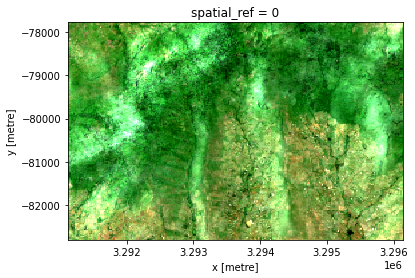

In [39]:
ref[['red','green','blue']].to_array().plot.imshow(robust=True);

In [70]:
(-np.log(ref[['emad','smad','bcmad']])).max().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      ()
Coordinates:
    spatial_ref  int32 0
Data variables:
    emad         float64 3.559
    smad         float64 8.004
    bcmad        float64 3.714>

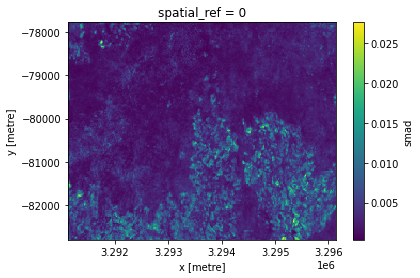

In [41]:
ref.smad.plot.imshow();

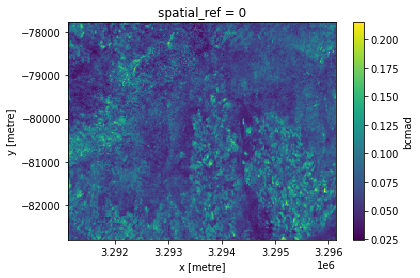

In [42]:
ref.bcmad.plot.imshow();

In [43]:
import hdstats

In [44]:
arr = data.to_array(dim='band').transpose('y','x','band','time').values

In [56]:
gm = hdstats.nangeomedian_pcm(arr, nocheck=False, eps=1e-6)

Automatically using 16 threads.


In [57]:
edist = hdstats.eucdist(arr, gm)
emad = np.nanmedian(edist, axis=2)
cdist = hdstats.cosdist(arr, gm)
smad = np.nanmedian(cdist, axis=2)

Automatically using 16 threads.
Automatically using 16 threads.


In [58]:
emad_pcm = hdstats.emad_pcm(arr, gm)
smad_pcm = hdstats.smad_pcm(arr, gm)

Automatically using 16 threads.
Automatically using 16 threads.


In [60]:
((ref.emad-emad_pcm)/ref.emad).max()

<xarray.DataArray 'emad' ()>
array(0.)
Coordinates:
    spatial_ref  int32 0

In [61]:
((ref.smad-smad_pcm)/ref.smad).max()

<xarray.DataArray 'smad' ()>
array(0.)
Coordinates:
    spatial_ref  int32 0

In [62]:
((ref.emad-emad)/ref.emad).max()

<xarray.DataArray 'emad' ()>
array(0.)
Coordinates:
    spatial_ref  int32 0

In [63]:
((smad_pcm-smad)/smad).max()

0.0